In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from functools import partial

from tree_extraction import Aho
from compute_pam import compute_combo_tensor, get_alpha
from example_graphs import make_tree
from utils import bfs_layout

In [2]:
import sys, os
sys.path.append(os.path.abspath('../anchor-word-recovery/'))

In [3]:
from learn_topics import Analysis, Params

In [4]:
def nice_tree_plot(t, ax = None, **kwargs):
    if ax is None:
        _, ax = plt.subplots()
    if t is None:
        return
    draw_kwargs = dict(with_labels=True, pos=bfs_layout(t))
    draw_kwargs.update(kwargs)
    nx.draw(t, **draw_kwargs)

In [5]:
tree = make_tree([3,3,3])
R = compute_combo_tensor(tree, alpha_func = partial(get_alpha, pexit=0.3, scale=1.0))

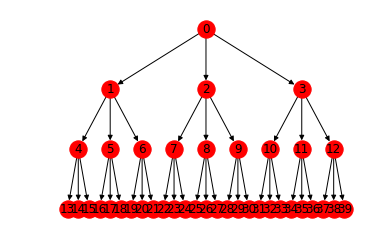

In [6]:
nice_tree_plot(tree)

In [7]:
C = Aho.get_ratio_matrix(R)

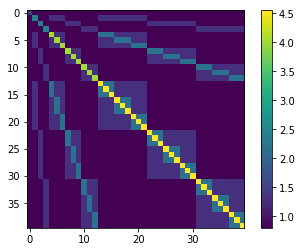

In [8]:
plt.imshow(C);
plt.colorbar();

In [9]:
constraints = Aho.get_constraints(C, threshold=1e-10)
len(constraints)

6804

In [10]:
constraints[-1].strength

0.5257142857142832

Find all distinct trees that can be generated by some prefix of `constraints`.  
Start with empty list; i.e., set `i = 0` and try `constraints[0:i]`.  
Then, for each `i > 0`, if `constraints[0:i]` is satisfied by prev tree, we know the result will be unchanged
and don't have to rebuild from scratch.

In [11]:
r = Aho.aho_tree_build(
    nodes = list(range(C.shape[0])),
    constraints = constraints[:2000])

In [12]:
IN = Aho.Internal

In [13]:
test_constraints = [
    ((14, 15, 16), True),
    ((34, 11, 12), True),
    ((IN(0), 8, 3), True),
    ((IN(0), 2, 3), True),
    ((IN(0), IN(1), 3), True),
    ((34, 11, 35), False),
    ((4, 5, 6), False),
]

for c, expected in test_constraints:
    result = Aho.tree_satisfies_constraint(r, c)
    assert result == expected, "For {}, expected {} but got {}".format(c, expected, result)
    print("{}: {}".format(c, result))

(14, 15, 16): True
(34, 11, 12): True
(IN(0), 8, 3): True
(IN(0), 2, 3): True
(IN(0), IN(1), 3): True
(34, 11, 35): False
(4, 5, 6): False


In [14]:
%%time
tree_seq = []
latest_tree = None
for i in range(len(constraints) + 1):
    print("\r{}".format(i), end="")
    if i == 0 or (latest_tree is not None and not Aho.tree_satisfies_constraint(latest_tree, constraints[i-1])):
        latest_tree = Aho.aho_tree_build(
            nodes = list(range(C.shape[0])),
            constraints = constraints[:i])
        tree_seq.append((i, latest_tree))
print("")

6804
CPU times: user 32.3 s, sys: 563 ms, total: 32.9 s
Wall time: 32.8 s


In [15]:
len(tree_seq)

37

In [16]:
import ipywidgets

In [17]:
@ipywidgets.interact(
    i = ipywidgets.IntSlider(0, 0, len(tree_seq) - 1))
def foo(i):
    fig, ax = plt.subplots(figsize=(20,4))
    ii, tree = tree_seq[i]
    nice_tree_plot(tree, ax=ax)
    suffix = "" if i == 0 else " (last = {})".format(constraints[ii-1])
    ax.set_title("after including {} constraints".format(ii) + suffix)

interactive(children=(IntSlider(value=0, description='i', max=36), Output()), _dom_classes=('widget-interact',…

In [18]:
# TODO: extract tree from simulated data
# TODO: extract tree from real data
# TODO: run the tree-building sequence on the above results